In [1]:
import subprocess
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def set_mpi_params(use: bool, proc: int, mult: int, ngram = 3):
    with open('gradle.properties', 'w') as file:
        file.write('MPI_USE=%s\n' % ('true' if use else 'false'))
        file.write('MPI_PROC=%s\n' % proc)
        file.write('MPI_NGRAM=%d\n' % ngram)
        file.write('MPI_MULT=%d\n' % mult)

In [3]:
def freqs(output: str):
    return { word: float(freq) for (word, freq) in re.findall(r'([а-я]+) -> (\d+.\d+)', output) }

In [4]:
mults = [1,10,20]
procs = [1,2,4,6,8,10,12,14,16]
df = pd.DataFrame(columns=['proc', 'mult', 'ms'])
t_10_95 = 2.26215716274
for mult in mults:
    for proc in procs:
        set_mpi_params(use=proc > 1, proc=proc, mult=mult)
        for i in range(10):
            res = subprocess.run(['gradle', 'mpi'], capture_output=True)
            out = res.stdout.decode('utf8')
            ms = int(re.findall(r'in (\d+) ms', out)[-1])
            df.loc[len(df)] = [proc, mult, ms]
        local = df[(df.proc == proc) & (df.mult == mult)]
        mean = local.ms.mean()
        std = local.ms.std()
        delta = std * t_10_95
        print('mult=%d, proc=%d: %d ms ± %d ms = [%d, %d] ms' % (mult, proc, mean, delta, mean - delta, mean + delta))
df.ms = df.ms.astype(int)

mult=1, proc=1: 1871 ms ± 51 ms = [1820, 1922] ms
mult=1, proc=2: 1583 ms ± 104 ms = [1478, 1687] ms
mult=1, proc=4: 1534 ms ± 49 ms = [1484, 1583] ms
mult=1, proc=6: 1797 ms ± 82 ms = [1715, 1879] ms
mult=1, proc=8: 2075 ms ± 84 ms = [1991, 2159] ms
mult=1, proc=10: 2298 ms ± 76 ms = [2221, 2375] ms
mult=1, proc=12: 2532 ms ± 132 ms = [2399, 2665] ms
mult=1, proc=14: 3007 ms ± 175 ms = [2832, 3183] ms
mult=1, proc=16: 2981 ms ± 404 ms = [2577, 3386] ms
mult=10, proc=1: 16127 ms ± 262 ms = [15865, 16390] ms
mult=10, proc=2: 8990 ms ± 873 ms = [8116, 9863] ms
mult=10, proc=4: 5731 ms ± 152 ms = [5579, 5884] ms
mult=10, proc=6: 5024 ms ± 189 ms = [4835, 5214] ms
mult=10, proc=8: 5173 ms ± 274 ms = [4899, 5447] ms
mult=10, proc=10: 5807 ms ± 295 ms = [5511, 6102] ms
mult=10, proc=12: 6381 ms ± 244 ms = [6136, 6625] ms
mult=10, proc=14: 7167 ms ± 251 ms = [6915, 7419] ms
mult=10, proc=16: 7929 ms ± 426 ms = [7502, 8355] ms
mult=20, proc=1: 33034 ms ± 3965 ms = [29068, 37000] ms
mult=20, pr

In [5]:
df.to_csv('data.csv')

In [6]:
freqs(out)

{'что': 0.42,
 'его': 0.37,
 'ост': 0.33,
 'ого': 0.32,
 'про': 0.3,
 'ото': 0.27,
 'как': 0.26,
 'ени': 0.26,
 'ста': 0.26,
 'при': 0.25,
 'ово': 0.23,
 'ест': 0.23,
 'ать': 0.23,
 'это': 0.23,
 'аза': 0.23,
 'все': 0.22,
 'оро': 0.21,
 'сто': 0.21,
 'енн': 0.21,
 'был': 0.21}

In [7]:
groups = df.groupby(['mult', 'proc'])
mean = groups.mean()
std = groups.std()
delta = std * t_10_95
lower = mean - delta
upper = mean + delta
agg = pd.concat([mean, lower, upper], axis=1)
agg.columns = ['means', 'upper', 'lower']
agg = agg / 1000
agg

means      upper      lower
mult proc                               
1    1      1.8717   1.820535   1.922865
     2      1.5833   1.478712   1.687888
     4      1.5340   1.484118   1.583882
     6      1.7972   1.715145   1.879255
     8      2.0757   1.991664   2.159736
     10     2.2982   2.221288   2.375112
     12     2.5324   2.399575   2.665225
     14     3.0078   2.832325   3.183275
     16     2.9818   2.577333   3.386267
10   1     16.1279  15.865231  16.390569
     2      8.9903   8.116851   9.863749
     4      5.7319   5.579419   5.884381
     6      5.0248   4.835208   5.214392
     8      5.1732   4.899074   5.447326
     10     5.8073   5.511813   6.102787
     12     6.3810   6.136680   6.625320
     14     7.1676   6.915857   7.419343
     16     7.9292   7.502968   8.355432
20   1     33.0345  29.068827  37.000173
     2     18.9043  16.203570  21.605030
     4     11.9500   9.583460  14.316540
     6     11.0460   8.817408  13.274592
     8     10.0723   9.139196  11.005404
     10    10.6420   9.894871  11.389129
     12    11.1804  10.306344  12.054456
     14    11.7772  11.211734  12.342666
     16    12.4781  11.110399  13.845801

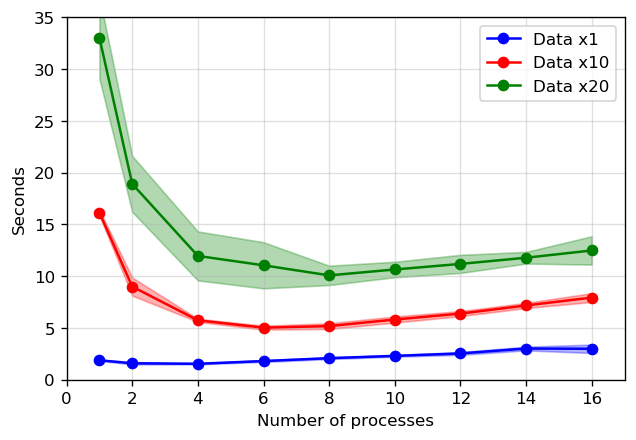

In [10]:
plt.figure(dpi=120)
plt.grid(alpha=0.4)
colors = {1: 'blue', 10: 'red', 20: 'green'}
for mult in mults:
    aggr = agg.loc[mult]
    plt.fill_between(aggr.index, aggr['lower'], aggr['upper'], color=colors[mult], alpha=0.3)
    plt.plot(aggr['means'], '-o', color=colors[mult])
plt.xlim(0, 17)
plt.xlabel('Number of processes')
plt.ylim(0, 35)
plt.ylabel('Seconds')
plt.legend(list(map(lambda x: "Data x" + str(x), mults)))
plt.show()

In [11]:
def draw_single(aggr, color):
    x_min = aggr.index.min() - 1
    x_max = aggr.index.max() + 1
    y_min = aggr['means'].min() - 1
    y_max = aggr['means'].max() + 1

    plt.figure(dpi=120)
    plt.grid(alpha=0.4)
    plt.fill_between(aggr.index, aggr['lower'], aggr['upper'], color=color, alpha=.3)
    plt.plot(aggr['means'], '-o', color=color)
    plt.xlim((x_min, x_max))
    plt.xlabel('Number of processes')
    plt.ylim((y_min, y_max))
    plt.ylabel('Seconds')
    plt.show()

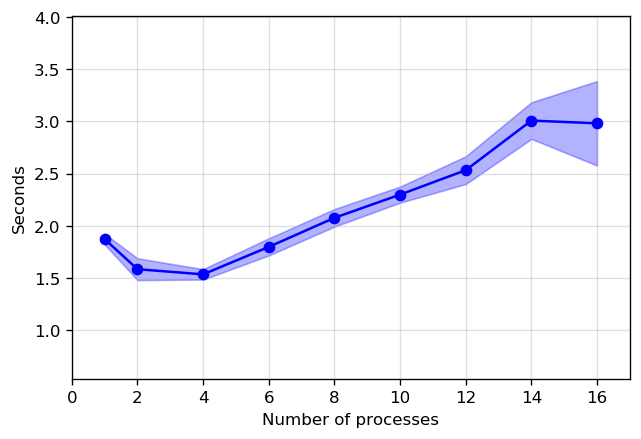

In [12]:
draw_single(agg.loc[1], colors[1])

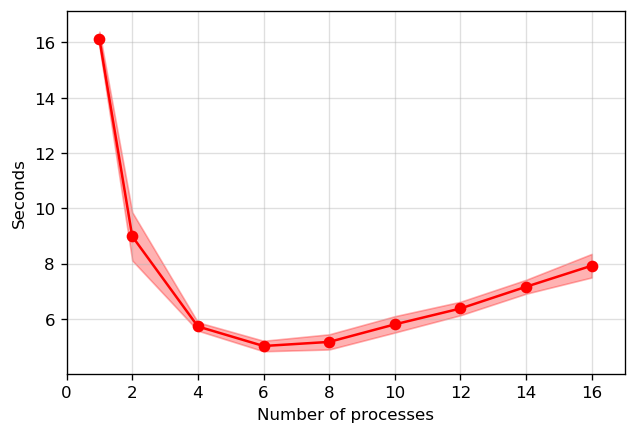

In [14]:
draw_single(agg.loc[10], colors[10])

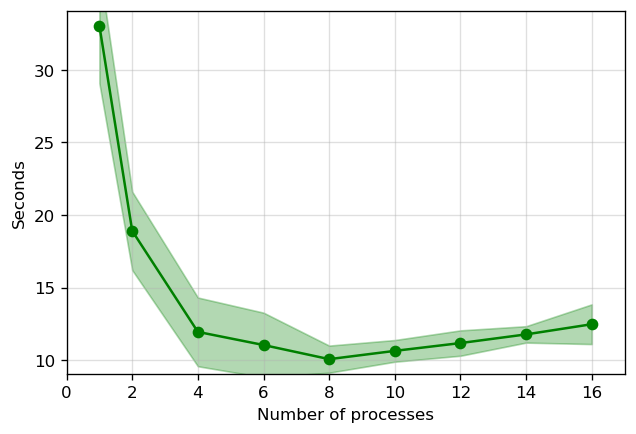

In [15]:
draw_single(agg.loc[20], colors[20])

In [16]:
spd = agg.drop(['upper', 'lower'], axis=1)
spd = spd.rename({'means': 'time'}, axis=1)
spd['mult'] = spd.index.droplevel(1)
spd['single_time'] = spd.apply(lambda x: spd.loc[x.mult, 1], axis=1).time
spd['speedup'] = spd.single_time / spd.time
speedup = spd['speedup']
pd.DataFrame(speedup)

speedup
mult proc          
1    1     1.000000
     2     1.182151
     4     1.220143
     6     1.041453
     8     0.901720
     10    0.814420
     12    0.739101
     14    0.622282
     16    0.627708
10   1     1.000000
     2     1.793922
     4     2.813709
     6     3.209660
     8     3.117587
     10    2.777177
     12    2.527488
     14    2.250112
     16    2.033988
20   1     1.000000
     2     1.747460
     4     2.764393
     6     2.990630
     8     3.279737
     10    3.104163
     12    2.954680
     14    2.804954
     16    2.647398

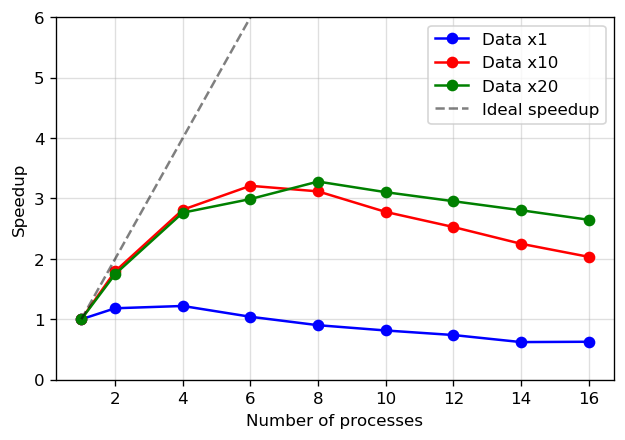

In [17]:
plt.figure(dpi=120)
plt.grid(alpha=0.4)
for mult in mults:
    plt.plot(speedup.loc[mult], '-o', color=colors[mult])
plt.plot(procs, procs, '--', color='k', alpha=0.5)
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.ylim(0, 6)
plt.legend(list(map(lambda x: "Data x" + str(x), mults)) + ['Ideal speedup'])
plt.show()